## Streetview House Number Recognition

### Image Classification

In this file I use two different types of neural networks to classify street view house number images (single digits).

Data: Street View House Numbers (SVHN): A large-scale dataset of house numbers in Google Street View images.

In [5]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline


In [18]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    #train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
 
#load training chunks
pickle_file = 'SVHN1.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset1 = save['train_dataset1']
  del save  # hint to help gc free up memory

pickle_file = 'SVHN2.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset2 = save['train_dataset2']
  del save  # hint to help gc free up memory

pickle_file = 'SVHN3.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset3 = save['train_dataset3']
  del save  # hint to help gc free up memory    


train_dataset = np.concatenate((train_dataset1, train_dataset2, train_dataset3), axis=0)
del train_dataset1, train_dataset2, train_dataset3
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (598388, 32, 32) (598388,)
Validation set (6000, 32, 32) (6000,)
Test set (26032, 32, 32) (26032,)


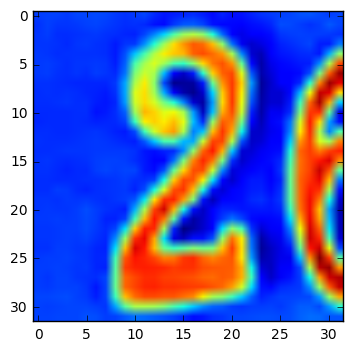

In [20]:
plt.imshow(train_dataset[11])


### Using a Fully Connected Graph

In [21]:
image_size = 32
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels


train_dataset2, train_labels2 = reformat(train_dataset, train_labels)
valid_dataset2, valid_labels2 = reformat(valid_dataset, valid_labels)
test_dataset2, test_labels2 = reformat(test_dataset, test_labels)


print('Training set', train_dataset2.shape, train_labels2.shape)
print('Validation set', valid_dataset2.shape, valid_labels2.shape)
print('Test set', test_dataset2.shape, test_labels2.shape)

Training set (598388, 1024) (598388, 10)
Validation set (6000, 1024) (6000, 10)
Test set (26032, 1024) (26032, 10)


In [22]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])




In [23]:
batch_size = 128
hidden = 1024

graph = tf.Graph()
with graph.as_default():
    dropout = 0.50
    keep_prob = tf.placeholder(tf.float32)
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset2)
    tf_test_dataset = tf.constant(test_dataset2)

    # Variables.
    weights={  
      'w1' : tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden])),
      'w2' : tf.Variable(
        tf.truncated_normal([hidden, num_labels]))
    }      

    biases={      
      'b1' : tf.Variable(tf.zeros([hidden])),

      'b2' : tf.Variable(tf.zeros([num_labels]))
    }  

    # Training computation.
    def compute_pred(input, weights, biases, dropout):
        hidden_layer = tf.matmul(input, weights['w1']) + biases['b1']
        hidden_layer = tf.nn.relu(hidden_layer)
        #Apply droputs to the output of hidden layer: >> dropout should be keep_prob??
#         hidden_layer = tf.nn.dropout(hidden_layer, dropout)
        last_layer = tf.matmul(hidden_layer, weights['w2']) + biases['b2']
        return last_layer 

    logits = compute_pred(tf_train_dataset, weights, biases, keep_prob)  
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    regularizers = (tf.nn.l2_loss(weights['w1']) + tf.nn.l2_loss(biases['b1']) +
                   tf.nn.l2_loss(weights['w2']) + tf.nn.l2_loss(biases['b2']))

    # Add the regularization term to the loss.
    loss += 3e-3 * regularizers



    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(compute_pred(tf_valid_dataset, weights, biases, 1.0))
    test_prediction = tf.nn.softmax(compute_pred(tf_test_dataset, weights, biases, 1.0))



In [24]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset2[offset:(offset + batch_size), :]
    batch_labels = train_labels2[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : dropout}
    session.run(
      [optimizer], feed_dict=feed_dict)
    if (step % 500 == 0):
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 1.0}
      l, predictions = session.run([loss, train_prediction], feed_dict=feed_dict)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2417.075684
Minibatch accuracy: 0.0%


/Users/aoliya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


Validation accuracy: 11.4%
Minibatch loss at step 500: 904.375610
Minibatch accuracy: 0.0%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 667.570068
Minibatch accuracy: 0.0%
Validation accuracy: 76.3%
Minibatch loss at step 1500: 494.416504
Minibatch accuracy: 0.0%
Validation accuracy: 76.9%
Minibatch loss at step 2000: 362.776794
Minibatch accuracy: 0.0%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 270.855774
Minibatch accuracy: 0.0%
Validation accuracy: 76.4%
Minibatch loss at step 3000: 199.381577
Minibatch accuracy: 0.0%
Validation accuracy: 79.5%
Test accuracy: 78.6%


### Using a ConvNet

In [25]:
image_size = 32
num_labels = 10
num_channels = 1 

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels


train_dataset2, train_labels2 = reformat(train_dataset, train_labels)
valid_dataset2, valid_labels2 = reformat(valid_dataset, valid_labels)
test_dataset2, test_labels2 = reformat(test_dataset, test_labels)


print('Training set', train_dataset2.shape, train_labels2.shape)
print('Validation set', valid_dataset2.shape, valid_labels2.shape)
print('Test set', test_dataset2.shape, test_labels2.shape)

Training set (598388, 32, 32, 1) (598388, 10)
Validation set (6000, 32, 32, 1) (6000, 10)
Test set (26032, 32, 32, 1) (26032, 10)


In [26]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [29]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset2)
    tf_test_dataset = tf.constant(test_dataset2)

    weights={  
      'w1' : tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)),
      'w2' : tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1)),
        'w3': tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)),
        'w4': tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
        
    }      

    biases={      
      'b1' : tf.Variable(tf.zeros([depth])),

      'b2' : tf.Variable(tf.constant(1.0, shape=[depth])),
        'b3' : tf.Variable(tf.constant(1.0, shape=[num_hidden])),
        'b4': tf.Variable(tf.constant(1.0, shape=[num_labels]))
    }      
    

  
 
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, weights['w1'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['b1'])
        conv = tf.nn.conv2d(hidden,  weights['w2'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['b2'])
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights['w3']) + biases['b3'])
        return tf.matmul(hidden, weights['w4']) +  biases['b4']

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [34]:
num_steps = 1001



with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  saver = tf.train.Saver() 

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels2.shape[0] - batch_size)
    batch_data = train_dataset2[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels2[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):      
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels2))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels2))
  save_path = saver.save(session, "svhn_single_model.ckpt")



Initialized
Minibatch loss at step 0: 3.412746
Minibatch accuracy: 25.0%
Validation accuracy: 10.8%
Minibatch loss at step 100: 2.061723
Minibatch accuracy: 25.0%
Validation accuracy: 24.3%
Minibatch loss at step 200: 0.496188
Minibatch accuracy: 87.5%
Validation accuracy: 42.6%
Minibatch loss at step 300: 1.078329
Minibatch accuracy: 56.2%
Validation accuracy: 50.4%
Minibatch loss at step 400: 0.817470
Minibatch accuracy: 68.8%
Validation accuracy: 58.6%
Minibatch loss at step 500: 1.354081
Minibatch accuracy: 75.0%
Validation accuracy: 56.9%
Minibatch loss at step 600: 0.597323
Minibatch accuracy: 87.5%
Validation accuracy: 65.2%
Minibatch loss at step 700: 0.495293
Minibatch accuracy: 87.5%
Validation accuracy: 68.6%
Minibatch loss at step 800: 0.225860
Minibatch accuracy: 100.0%
Validation accuracy: 69.5%
Minibatch loss at step 900: 0.469430
Minibatch accuracy: 81.2%
Validation accuracy: 71.0%
Minibatch loss at step 1000: 0.580392
Minibatch accuracy: 81.2%
Validation accuracy: 72.2

## Conclusion

Our fully connected graph is yielding better results than our ConvNet. I wasn't expecting this and it could have to do with the ConvNet design or number of layers. Optimizing this will be a #FutureWork

### Restoring Model

Ideally we'd want to reuse the model (classifer) later in an actual application like in a web service or Android app. 
Having some issues with restoring the model #FutureWork

In [41]:


graph = tf.Graph()

with graph.as_default():

  weights={  
      'w1' : tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)),
      'w2' : tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1)),
        'w3': tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)),
        'w4': tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
        
    }      

    biases={      
      'b1' : tf.Variable(tf.zeros([depth])),

      'b2' : tf.Variable(tf.constant(1.0, shape=[depth])),
        'b3' : tf.Variable(tf.constant(1.0, shape=[num_hidden])),
        'b4': tf.Variable(tf.constant(1.0, shape=[num_labels]))
    } 

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  sess.run(tf.initialize_all_variables())
    
  # Restore variables from disk.
  ss = saver.restore(sess, "svhn_single_model.ckpt")
  print("Model restored.")
  # Do some work with the model

ValueError: No variables to save